# (연구&교수님) HST old exam (Python)

신록예찬  
2021-07-14

### About this doc

`-` 앞선 R예제보다 좀더 노이지한 자료

### data

In [2]:
import pandas as pd

In [6]:
testdata=pd.read_csv('~/Dropbox/03_Yechan3/연구/교수님이랑/HST/2021-07-14-hstex.csv') # data is in https://github.com/miruetoto/yechan/tree/master/_notebooks

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

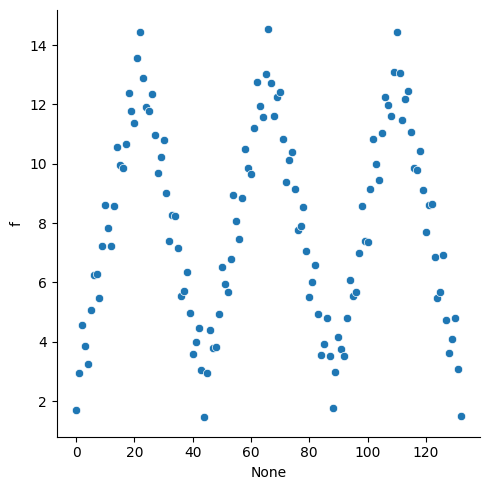

In [9]:
sns.relplot(data=testdata,x=testdata.index,y='f')

#### Local view

`-` local view에서의 structure가 뚜렷하게 구별되는것은 아님

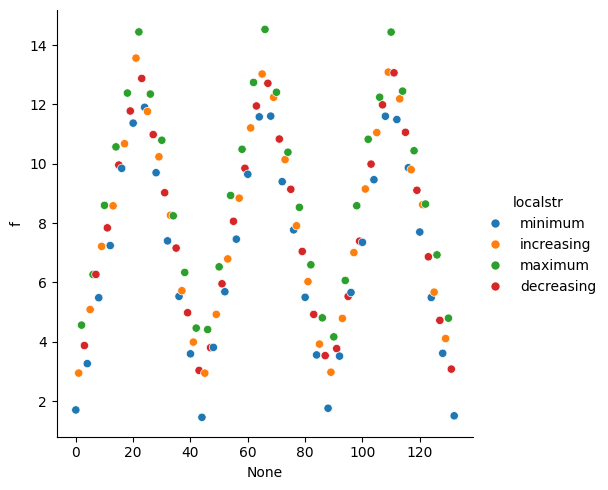

In [10]:
sns.relplot(data=testdata,x=testdata.index,y='f',hue='localstr')

#### global view

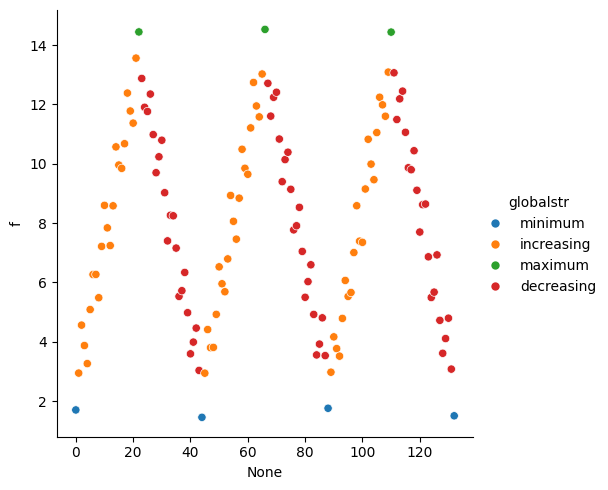

In [11]:
sns.relplot(data=testdata,x=testdata.index,y='f',hue='globalstr')

### hst

In [12]:
class GraphSignal: 
    def __init__(self,V,W,f):
        self.f=np.array(f) 
        self.V=V 
        self.W=np.array(W)
        self.n=len(self.f)
        self.degree=np.sum(np.array(self.W),0)
        self.initdist=self.degree/np.sum(self.degree) 
        
class HeavySnowTransform:  #hst(f,W,V,τ=τ,b=0.03,γ=1)
    def __init__(self,graphsignal):
        self.n=graphsignal.n
        self.f=graphsignal.f
        self.V=graphsignal.V
        self.graphweight=graphsignal.W
        #self.degree=graphsignal.degree
        self.initdist=graphsignal.initdist
        self._initialize()
    
    def _initialize(self):
        self.tau=0
        self.b=0
        self.trajectory=[0]
        self.flowcount=[0]
        self.snowygrounds=pd.DataFrame(data={'h0':self.f})                    
        self.eucliddistance=(np.array(self.f)[:,np.newaxis]-np.array(self.f)[np.newaxis,:])**2
        self.snowdistance=np.zeros((self.n,self.n))
        self.euclidweight=np.zeros((self.n,self.n))
        self.snowweight=np.zeros((self.n,self.n))
        
    def _snowonce(self,ell,b,maxflow):
        W=self.graphweight>np.asmatrix(np.random.random((self.n,self.n)))
        hnext=np.array(self.snowygrounds.iloc[:,-1])
        currentnode=self.trajectory[-1]
        flowcount=self.flowcount[-1]
        # 1. h(u) <- h(u)+b : update current node when flowcound > 0 
        hnext[currentnode]=hnext[currentnode]+b
        # 2. check that: are there any nodes to which snow can flow from u. 
        neighbor=np.where(W[currentnode,:]>0)[1] ## Nu is np.array
        if len(neighbor)==0: downstream=np.array([])
        else: downstream=neighbor[list((np.where(hnext[neighbor]<=hnext[currentnode]))[0])]
        # 3. check flowable 
        flowable = len(downstream)>0 and flowcount < maxflow 
        # 4. determine flow or block
        if flowable==0: # block!
            node0=np.random.choice(self.n,1,p=self.initdist).item()
            neighbor=np.where(W[node0,:]>0)[1] 
            downstream=neighbor[list((np.where(hnext[neighbor]<=hnext[node0]))[0])]
            if len(downstream)==0: 
                nextnode=node0
            else: 
                nextnode=np.random.choice(list(downstream),1).item()
            flowcount=0
        else: #flow
            nextnode=np.random.choice(list(downstream),1).item()
            flowcount=flowcount+1
        self.snowygrounds['h%s' % ell]=hnext
        self.flowcount=self.flowcount+[flowcount]
        self.trajectory=self.trajectory+[nextnode]    
        
        self.snowygrounds_f['h%s' % ell]=self.f
        self.snowygrounds_sumxi['h%s' % ell]=hnext-self.f

    def _getdegreematrix(self,matrix):
        return np.diag(np.sum(matrix,1))
    
    def _normalize(self,matrix): 
        return np.sqrt(self._getdegreematrix(matrix))@matrix@np.sqrt(self._getdegreematrix(matrix))
    
    def _updateeuclidweight(self):
        self.euclidweight=np.exp(-self.eucliddistance/(self.b**2))-np.eye(self.n)
        
    def _updatesnowdistance(self):
        self.snowdistance=np.sum((np.array(self.snowygrounds)[:,np.newaxis,:]-np.array(self.snowygrounds)[np.newaxis,:,:])**2,axis=-1)
        
    def _updatesnowweight(self):
        self.snowweight=np.exp(-self.snowdistance/(self.tau*self.b**2))-np.eye(self.n)
        
    def snow(self,tau,b=1,maxflow=100):
        self._initialize()
        self.b=b
        self.tau=tau
        print('HST (τ= %s, b=%s)' % (tau,b))
        for ell in np.arange(1,tau+1): 
            print('\r'+str(ell)+'/'+str(tau),sep='',end='')
            self._snowonce(ell,b,maxflow)
        print('\n'+'HST completed and all history is recorded.')
        self._updatesnowdistance()
        self._updatesnowweight()
        self._updateeuclidweight()

`-` define graph signal

In [13]:
#f=np.array([-1,-1,-1,1,-1,-1,-1,1,1,1,-1,1,1,1])*1.0
import numpy as np
f=testdata.f
n=len(f)
V=list(range(n))
W=np.zeros([n,n])
for i in range(n):
    for j in range(n):
        if abs(i-j)<=1: W[i,j]=1
W[0,0]=1
W[n-1,n-1]=1
gs1=GraphSignal(V,W,f)

`-` hst with $\tau=10000$

In [14]:
hst1=HeavySnowTransform(gs1)
hst1.snow(tau=10000,b=0.005,maxflow=1)
plt.imshow(hst1.snowdistance)

HST (τ= 10000, b=0.005)
1/10000

`-` hst with $\tau=50000$

HST (τ= 50000, b=0.003)
50000/50000
HST completed and all history is recorded.

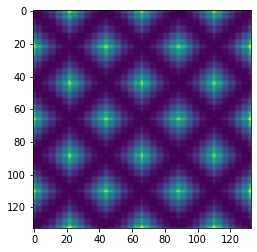

In [213]:
hst2=HeavySnowTransform(gs1)
hst2.snow(tau=50000,b=0.003,maxflow=1)
plt.imshow(hst2.snowdistance)

`-` hst with $\tau=100000$

HST (τ= 100000, b=0.003)
100000/100000
HST completed and all history is recorded.

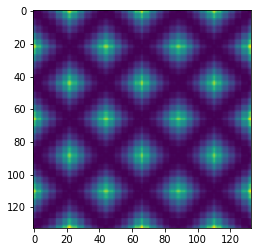

In [214]:
hst3=HeavySnowTransform(gs1)
hst3.snow(tau=100000,b=0.003,maxflow=1)
plt.imshow(hst3.snowdistance)

### PCA

In [215]:
from sklearn.decomposition import PCA 
p1=PCA(n_components=3)
p2=PCA(n_components=3)
p3=PCA(n_components=3)

p1.fit(hst1.snowygrounds)
p2.fit(hst2.snowygrounds)
p3.fit(hst3.snowygrounds)

r1=p1.transform(hst1.snowygrounds)
r2=p2.transform(hst2.snowygrounds)
r3=p3.transform(hst3.snowygrounds)


### Plot

`-` $\tau=10000$: local view를 반영

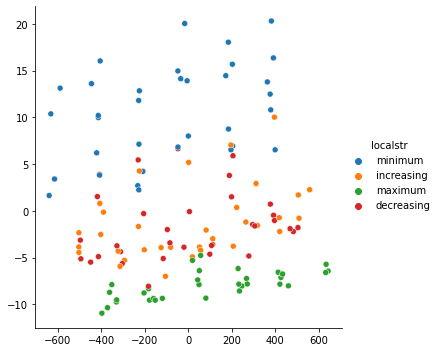

In [216]:
sns.relplot(x=r1[:,0],y=r1[:,1],hue=testdata.localstr)

`-` $\tau=100000$: global view를 반영

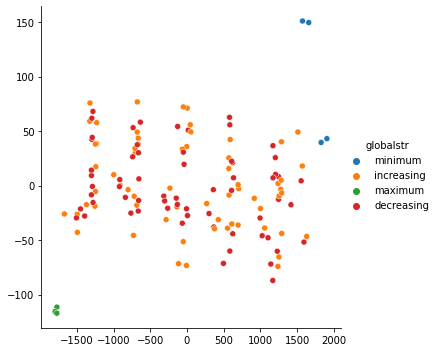

In [221]:
sns.relplot(x=r3[:,0],y=r3[:,1],hue=testdata.globalstr)